In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import csv

# **1. Create HR / LR datasets and train, validation and test sets**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

#transforming high resolution data to tensors and is labeled
#HRdataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360/Bird_Data_HR', transform=transforms.ToTensor())
#Original
HRdataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360/APS360 Project/Code_Data/Bird_Data_HR', transform=transforms.ToTensor())
#for demo
#HRdataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360/Bird_Data_HR', transform=transforms.ToTensor()) 


#transforming low resolution data to tensors 
#LRdataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360/Bird_Data_LR', transform=transforms.ToTensor())
#Original ->
LRdataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360/APS360 Project/Code_Data/Bird_Data_LR', transform=transforms.ToTensor())
#for demo
#LRdataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/APS360/personal_bird_test_images/bird_pic224', transform=transforms.ToTensor()) 
print(len(HRdataset))
print(len(LRdataset))

2000
2000


In [5]:
# start with subset of datasets for hyperparameter tuning, at the end use more
LRdataset = torch.utils.data.Subset(LRdataset, range(2000))
HRdataset = torch.utils.data.Subset(HRdataset, range(2000))

In [6]:
# train val test split of LR dataset
n = len(LRdataset)  # total number of examples
n_val_and_test = int(0.3 * n)  # take ~30% for val/test
val_and_test_set = torch.utils.data.Subset(LRdataset, range(n_val_and_test))  # take first 30%
train_set_lr = torch.utils.data.Subset(LRdataset, range(n_val_and_test, n))  # take the rest


n = n_val_and_test
n_test = int(0.5*n)
val_set_lr = torch.utils.data.Subset(val_and_test_set, range(n_test))  # take first 50%
test_set_lr = torch.utils.data.Subset(val_and_test_set, range(n_test, n))

print('LOW RES len train/val/test:', len(train_set_lr), len(val_set_lr), len(test_set_lr))

LOW RES len train/val/test: 1400 300 300


In [7]:
# train val test split of HR dataset
n = len(HRdataset)  # total number of examples
n_val_and_test = int(0.3 * n)  # take ~30% for val/test
val_and_test_set = torch.utils.data.Subset(HRdataset, range(n_val_and_test))  # take first 30%
train_set_hr = torch.utils.data.Subset(HRdataset, range(n_val_and_test, n))  # take the rest 

n = n_val_and_test
n_test = int(0.5*n)
val_set_hr = torch.utils.data.Subset(val_and_test_set, range(n_test))  # take first 50%
test_set_hr = torch.utils.data.Subset(val_and_test_set, range(n_test, n))
print('HIGH RES len train/val/test:', len(train_set_hr), len(val_set_hr), len(test_set_hr))

HIGH RES len train/val/test: 1400 300 300


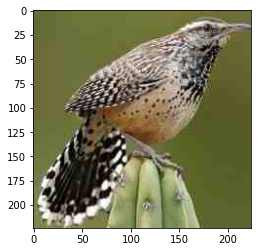

In [8]:
# visualizing samples
tensor_img = train_set_lr[30][0]
img1 = tensor_img.permute(1, 2, 0)
plt.imshow(img1)

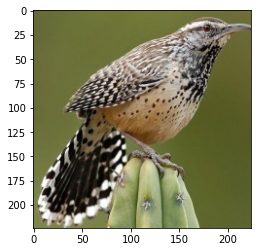

In [9]:
tensor_img2 = train_set_hr[30][0]
img2 = tensor_img2.permute(1, 2, 0)
plt.imshow(img2)

# **2. Create SRCNN and train code**

In [10]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.name = "SRCNN"
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 128, 
                               kernel_size = 9, 
                               padding = 9//2,
                               stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 128, 
                               out_channels = 64, 
                               kernel_size = 5, 
                               padding = 5//2, 
                               stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, 
                               out_channels = 3, 
                               kernel_size = 5, 
                               padding = 5//2, 
                               stride = 1)

    def forward(self, img):
        img = self.conv1(img)
        img = F.relu(img)
        img = self.conv2(img)
        img = F.relu(img)
        output = self.conv3(img)
        return output

In [ ]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)#, 
                                 #,weight_decay=1e-5) # <--
    train_loader_lr = torch.utils.data.DataLoader(train_set_lr, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    train_loader_hr = torch.utils.data.DataLoader(train_set_hr, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    
    val_loader_lr = torch.utils.data.DataLoader(val_set_lr, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    val_loader_hr = torch.utils.data.DataLoader(val_set_hr, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    

    
    # set up empty numpy arrays to store loss vals
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    outputs = []
    n = 1
    for epoch in range(num_epochs):
      lr_dataloader_iterator = iter(train_loader_lr)

      cumulative_loss = 0

      for i, lr_data in enumerate(train_loader_hr):
          try:
            hr_data = next(lr_dataloader_iterator)
          except StopIteration:
            lr_dataloader_iterator = iter(train_loader_lr)
            hr_data = next(lr_dataloader_iterator)
        
          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            lr_data = lr_data.cuda()
            hr_data = hr_data.cuda()
          #############################################

          #print('past try statement')  
          img_lr, _ = lr_data
          img_hr, _ = hr_data
          upscaled = model(img_lr)
          #print('past model')
          upscaled = upscaled.view(-1, 224 * 224)
          img_hr = img_hr.view(-1, 224 * 224)
          #print('past img.view')
          loss = criterion(upscaled, img_hr)
          #print('loss calc\'d')
          loss.backward()
          #print('backward propogated')
          optimizer.step()
          optimizer.zero_grad()

          cumulative_loss += loss.item()
          n += 1


      train_loss[epoch] = cumulative_loss / n
      val_loss[epoch] = calc_validation_loss(model, val_loader_lr, val_loader_hr, criterion)

      print('Epoch', epoch+1, 'Stats (train_loss, val_loss):', train_loss[epoch], val_loss[epoch])
      
      #torch.save(model_2000_20epoch.state_dict(), "model_2000_20epoch_SD_midsave")
      #torch.save(model_2000_20epoch, "model_2000_20epoch_midsave")

      outputs.append((epoch, upscaled, img_hr),)

    return outputs

In [ ]:
def calc_validation_loss(model, val_loader_lr, val_loader_hr, criterion):
    cumulative_loss = 0
    n = 1

    lr_dataloader_iterator = iter(val_loader_lr)

    cumulative_loss = 0

    for i, lr_data in enumerate(val_loader_hr):
      
          print('----- start val iter', n)
          try:
            hr_data = next(lr_dataloader_iterator)
          except StopIteration:
            lr_dataloader_iterator = iter(val_loader_lr)
            hr_data = next(lr_dataloader_iterator)
        
          #############################################
          # To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            lr_data = lr_data.cuda()
            hr_data = hr_data.cuda()
          #############################################

          #print('past try statement')  
          img_lr, _ = lr_data
          img_hr, _ = hr_data
          upscaled = model(img_lr)
          #print('past model')
          upscaled = upscaled.view(-1, 224 * 224)
          img_hr = img_hr.view(-1, 224 * 224)
          #print('past img.view')
          loss = criterion(upscaled, img_hr)
          print('-- finish val iter ---', n)
        
          cumulative_loss += loss.item()
          n += 1

    loss = cumulative_loss / n

    return loss

# **3. Hyperparamter Tuning**

In [ ]:
############# Iteration 1: Deafult Parameters #############
use_cuda = True
model_t1 = SRCNN()
max_epochs = 5
outputs = train(model_t1, num_epochs=max_epochs)

In [ ]:
############# Iteration 2: Kernels 5x5 #############
use_cuda = True
model_t2 = SRCNN()
max_epochs = 5
outputs = train(model_t2, num_epochs=max_epochs)

----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 1 Stats (train_loss, val_loss): 0.06504011643119156 0.026400506496429443
----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 2 Stats (train_loss, val_loss): 0.013010378740727902 0.015833440547188122
----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 3 Stats (train_loss, val_loss): 0.005562970838086171 0.009517951247592768
----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 4 Stats (train_loss, val_loss): 0.0025619960165229336 0.005910726264119148
----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 5 Stats (train_loss, val_loss): 0.0015609862360482414 0.0045663023677965


torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])


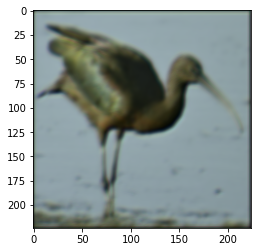

In [ ]:
img = test_set_lr[1][0]
upscaled = model_t2(img[None, ...])
print(upscaled.size())
upscaled = upscaled.squeeze()
print(upscaled.size())
upscaled = upscaled.permute(1, 2, 0)
upscaled = upscaled.detach().numpy()
plt.imshow(upscaled)

In [ ]:
############# Iteration 3: First kernel 11x11, Channels 3-128-64-3 #############
use_cuda = True
model_t3 = SRCNN()
max_epochs = 5
outputs = train(model_t3, num_epochs=max_epochs)

----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 1 Stats (train_loss, val_loss): 0.05767565732821822 0.0131448432803154
----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 2 Stats (train_loss, val_loss): 0.00625286710759004 0.006827236153185368
----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 3 Stats (train_loss, val_loss): 0.002578069731085138 0.0036943118708829084
----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 4 Stats (train_loss, val_loss): 0.0013289922559312705 0.0030537618634601436
----- start val iter 1
-- finish val iter --- 1
----- start val iter 2
-- finish val iter --- 2
Epoch 5 Stats (train_loss, val_loss): 0.000835055808743669 0.0023669510458906493


torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])


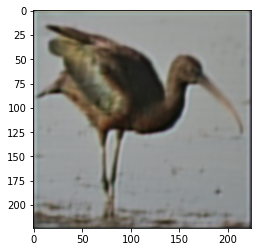

In [ ]:
img = test_set_lr[1][0]
upscaled = model_t3(img[None, ...])
print(upscaled.size())
upscaled = upscaled.squeeze()
print(upscaled.size())
upscaled = upscaled.permute(1, 2, 0)
upscaled = upscaled.detach().numpy()
plt.imshow(upscaled)

In [ ]:
############# Iteration 4: First kernel 9x9, Channels 3-128-64-3 #############
####Best output - use for model#####
use_cuda = True
model_t4 = SRCNN()
max_epochs = 5
outputs = train(model_t4, num_epochs=max_epochs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])


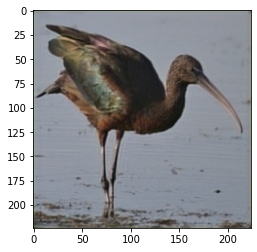

In [ ]:
img = test_set_lr[1][0]
upscaled = model_t4(img[None, ...])
print(upscaled.size())
upscaled = upscaled.squeeze()
print(upscaled.size())
upscaled = upscaled.permute(1, 2, 0)
upscaled = upscaled.detach().numpy()
plt.imshow(upscaled)

# **4. Train model on best hyperparameters for 50 epochs and Test**

In [ ]:
use_cuda = True
model_2000_50epoch = SRCNN()
max_epochs = 50
outputs = train(model_2000_50epoch, num_epochs=max_epochs)

In [ ]:
###### Saving #######
##State dict
model_save_name = 'model_trained_SD_run2.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model_2000_50epoch.state_dict(), path)

##Model path 
model_save_name = 'model_trained_modelversion_run2.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model_2000_50epoch,path)

torch.save(model_2000_50epoch.state_dict(), "model_2000_20epoch_SD")
torch.save(model_2000_50epoch, "model_2000_20epoch")

In [11]:
##Load the model
model_2000_50epoch = torch.load("/content/drive/MyDrive/APS360/APS360 Project/Trained_model_versions/model_trained_modelversion_run2.pt")

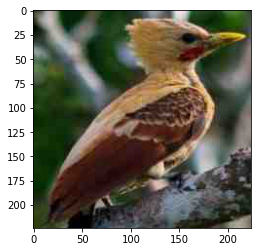

In [12]:
##print low rez image to be tested
img_view = test_set_lr[94][0]
img_view = img_view.permute(1, 2, 0)
plt.imshow(img_view)

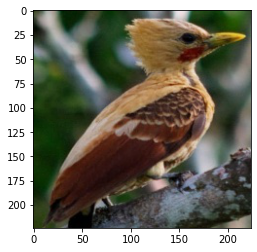

In [13]:
##print high rez image to be tested
img_view = test_set_hr[94][0]
img_view = img_view.permute(1, 2, 0)
plt.imshow(img_view)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


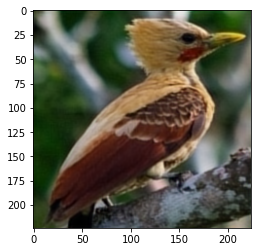

In [15]:
##pass low rez into trained model and look at output

model_2000_50epoch = torch.load("/content/drive/MyDrive/APS360/APS360 Project/Trained_model_versions/model_trained_modelversion_run2.pt")

img_test_intomodel = test_set_lr[94][0]
upscaled_image  = (model_2000_50epoch(img_test_intomodel[None, ...]))
upscaled_image = upscaled_image.squeeze()
upscaled_image = upscaled_image .permute(1, 2, 0)
upscaled_image = upscaled_image .detach().numpy()
plt.imshow(upscaled_image )

# **5. Condensed for video demo**

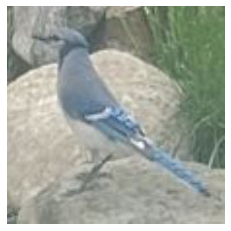

In [ ]:
#FOR DEMO VISUALIZING Original IMAGE
tensor_img = LRdataset[1][0]
img1 = tensor_img.permute(1,2,0)
plt.axis('off')
plt.imshow(img1)
plt.savefig('pic1LR.png', bbox_inches='tight', pad_inches = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


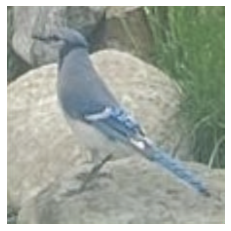

In [ ]:
#for demo testing
model_2000_50epoch = torch.load("/content/drive/MyDrive/APS360/Trained_model_versions/model_trained_modelversion_run2.pt")
img_test_intomodel = LRdataset[1][0]
upscaled_image  = (model_2000_50epoch(img_test_intomodel[None, ...]))
upscaled_image = upscaled_image.squeeze()
upscaled_image = upscaled_image .permute(1, 2, 0)
upscaled_image = upscaled_image .detach().numpy()
plt.axis('off')
plt.imshow(upscaled_image )

plt.savefig('pic3Upscaled.jpeg', bbox_inches='tight', pad_inches = 0)

# **Appendix - Add noise to dataset (NOT USED)**

In [ ]:
#######ADDING NOISE TO DATASET#################
##currently I have created a noisy version of the HR and LR datasets but not passed them in to model
##take 15m 32s to run for one loop
noise = 0.5 

HRdataset_noise = []
for data in HRdataset:
  img, _ = data
  img_noisy = img + noise * torch.randn(*img.shape)
  img_noisy = np.clip(img_noisy, 0., 1.) ##clip it so its between 0 and 1
  HRdataset_noise.append(img_noisy)

LRdataset_noise = []
for data in LRdataset:
  img, _ = data
  img_noisy = img + noise * torch.randn(*img.shape)
  img_noisy = np.clip(img_noisy, 0., 1.) ##clip it so its between 0 and 1
  HRdataset_noise.append(img_noisy)

"""
tensor = HRdataset[0][0]
img = tensor.permute(1, 2, 0)
img_noisy = img + noise * torch.randn(*img.shape)
plt.imshow(img_noisy)
"""

"""
print(HRdataset_noise[0])
img = tensor.permute(1, 2, 0)
img_noisy = img + noise * torch.randn(*img.shape)
plt.imshow(img_noisy)
"""

'\ntensor = HRdataset[0][0]\nimg = tensor.permute(1, 2, 0)\nimg_noisy = img + noise * torch.randn(*img.shape)\nplt.imshow(img_noisy)\n'